The format for PVT is

Time X

Position at time X in M1S (all 6 degrees of freedom)

Velocity at time X in M1S (all 6 degrees of freedom)

If Time X is < current time - 5 s then the PVT will be aborted.

I will basically send the PVT as "I want you at this position in 0.5 seconds from now" and update that at the rate determined by the timestamps. So we will always be aiming at a target 0.5 seconds in the future until we hit the end of the file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.jet()

import sys
sys.path.insert(0, '../')
from M1S_tools import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
## bending modes & influence matrices etc from Buddy #####################
ML actuators =  165 165
Afn =  (6991, 165)
fv =  (165, 165)
U matrix (6991, 165)
N node =  6991
## bending modes & influence matrices etc from Trupti #####################
N actuators =  170
Afz =  (27685, 170)
Afx =  (27685, 170)
Afy =  (27685, 170)
U matrix (27685, 170)
V matrix (170, 170)
S matrix (170, 170)
N node =  27685


<Figure size 640x480 with 0 Axes>

### Optical Testing configuration

In [ ]:
omega_arcsec = 0.1
arc_length_arcsec = 50
time_interval_s = 50

### Optical Testing Dryrun configuration

In [2]:
omega_arcsec = 0.2
arc_length_arcsec = 20
time_interval_s = 0.1 #10 Hz

### Numerical Testing configuration

In [ ]:
#for testing; easier visualization.
omega_arcsec = 0.1 *3600 *10 #turn it into 1 deg/s
arc_length_arcsec = 50 *3600 /50*360 #turn it into 360 deg
time_interval_s = 20

# Start

In [3]:
total_time_s = arc_length_arcsec/omega_arcsec
total_time_m = total_time_s/60.
n_time = int(total_time_s/time_interval_s)
print('This will take %.1f minutes = %.1f seconds'%(total_time_m, total_time_s))
print('Number of samples in time = %d'%n_time)

omega_rad = omega_arcsec/3600./180*np.pi
tt = np.linspace(0,time_interval_s*(n_time-1), n_time) #time vector
theta_m1s7 = omega_rad*tt
v_mag = r_S1_center_in_S7*omega_rad

This will take 1.7 minutes = 100.0 seconds
Number of samples in time = 1000


### our convention, for all CSs, is the rotations follow the order: do translations. thenRx, then Ry, then Rz

In [4]:
p_m1s7 = np.zeros((n_time, 6))
v_m1s7 = np.zeros((n_time, 6))
p_m1b = np.zeros_like(p_m1s7)
v_m1b = np.zeros_like(v_m1s7)
p_m1s = np.zeros_like(p_m1s7)
v_m1s = np.zeros_like(v_m1s7)

#just think of this segment as M1S1, whose center is on the +y axis of M1S7 CS.
#it would also work if we think of this as M1S2, or M1S3, in the end, the results would be same.
#but it is easier to visualize it if the segment center is on the +y axis of M1S7 CS.
#let's spin in clockwise direction when viewed from the sky
p_m1s7[:,0] = r_S1_center_in_S7*np.sin(theta_m1s7) #x
p_m1s7[:,1] = r_S1_center_in_S7*np.cos(theta_m1s7) #y
p_m1s7[:,2] = surfFunc(r_S1_center_in_S7**2) #z
#Rx, x rotation, how is the segment oriented in m1s7 at this moment in time, 
#we use the x-y plane of M1S1 as the reference when we define the "orientation"
p_m1s7[:,3] = np.radians(theta_M1S_deg) #unit is rad
p_m1s7[:,4] = 0 #Ry, y rotation
p_m1s7[:,5] = -theta_m1s7 #Rz, z rotation

v_m1s7[:,0] = v_mag*np.cos(theta_m1s7) #vx
v_m1s7[:,1] = -v_mag*np.sin(theta_m1s7) #vy
v_m1s7[:,2] = 0 #vz
v_m1s7[:,3] = 0 #is Rx changing with time? no
v_m1s7[:,4] = 0 #is Ry changing with time? no
#is Rz changing with time? yes,
v_m1s7[:,5] = -omega_rad # unit is rad/s; Rz is getting more and more negative with t

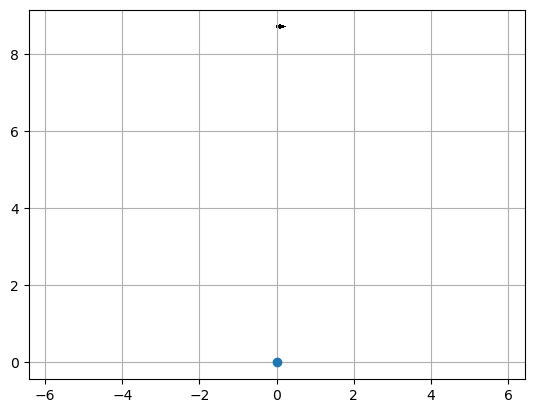

In [5]:
#plt.plot(p_m1s7[:,0], p_m1s7[:,1],'-o')
plt.quiver(p_m1s7[:,0], p_m1s7[:,1], v_m1s7[:,0], v_m1s7[:,1])
plt.plot(0,0,'o')
plt.axis('equal')
plt.grid();
#for Numerical testing configuration, we should see a circle.

In [16]:
## use meters and radians everywhere...
#x_m1s1o = p_m1s7[0,:3]
x_m1b1o = np.array([0, 8818.625, 602.002])/1000.
#R_m1b1 = np.array([[-1,0,0], [0, 0.9723, 0.2338], [0,0.2338, -0.9723]])
cb = np.cos(np.radians(theta_M1B_deg))
sb = np.sin(np.radians(theta_M1B_deg))
R_m1b1 = np.array([[-1,0,0], [0, cb, sb], [0,sb, -cb]])
def T_m1b1(x):
    return R_m1b1@ (x-x_m1b1o)
def T_m1b1_vec(x):
    return T_m1b1(x) - T_m1b1(np.array([0,0,0]))
def T_m1b1_rot(x):
    #the 1st term below gives you the rotation, which is represented by Rx. 
    #we want the orientation, which is why we need the 2nd term, to define a starting position of that Rx motion.
    return T_m1b1_vec(x) - np.array([np.radians(theta_M1B_deg), 0, 0])

#### we need to transform these from M1S7 CS to M1B1 CS. (actually, we need M1S1, not M1B1; but this was done before I understood that)

# Ignore this section.

In [ ]:
#this is a test vector from DOC-1118
x_tst1 = np.array([4330.127, 2500, 9000])/1000 #x,y,z in M1S7
#x,y,z in M1B1 should be [−4330.127, −4179.865, −9642.620]
T_m1b1(x_tst1)

In [ ]:
print(v_m1s7.shape)
v_m1s7_tst = v_m1s7[9,:3] #for Numerical testing config, this is after 180 deg rotation
print(v_m1s7_tst) #for Numerical tsting config, the vector has been reversed in x (compared to t=0)
#we know this is wrong for a vector. The large y component below verifies it is wrong
print('wrong: ', T_m1b1(v_m1s7_tst)) 
print(T_m1b1_vec(v_m1s7_tst)) #another negative sign added, because +x in M1S7 CS is -x in M1B1

In [ ]:
print(v_m1s7.shape)
R_m1s7_tst0 = v_m1s7[0,3:] #for Numerical testing config, this is t=0
print(R_m1s7_tst0) 
print(T_m1b1_vec(R_m1s7_tst0)) #for Numerical tsting config, the Rz vector has been decomposed into Ry & Rz

R_m1s7_tst1 = v_m1s7[9,3:] #for Numerical testing config, this is after 180 deg rotation
print(R_m1s7_tst1) #for Numerical tsting config, the vector remains same (compared to t=0)
print(T_m1b1_vec(R_m1s7_tst1)) #for Numerical tsting config, the vector remains unchanged

In [ ]:
#We could make theta_B a variable
#if theta_B = 0, check Rz transformation. 
#this is not done yet
#yes, in principle, even the order of Rx, Ry, Rz matters, but we are dealing with a simplified case where Rx = Ry = 0.
# the rotation vector should follow R' = T R? ChatGPT says yes it works

In [ ]:
for i in range(n_time):
    p_m1b[i,:3] = T_m1b1(p_m1s7[i,:3])
    v_m1b[i,:3] = T_m1b1_vec(v_m1s7[i,:3])
    p_m1b[i,3:] = T_m1b1_vec(p_m1s7[i,3:])
    v_m1b[i,3:] = T_m1b1_vec(v_m1s7[i,3:])

#### If you lie down on the floor at ML, feet toward parent center (or M2 interferometer), mirror will move to your lower left. 

### In M1S1 and M1S7, we will start with a +x, -y, -Rz motion. That is my prediction. Let's check the math

#### we need to transform these from M1S7 CS to M1S1 CS.

In [6]:
## use meters and radians everywhere...
x_m1s1o = p_m1s7[0,:3] #in meter
#R_m1s1 = np.array([[1,0,0], [0, 0.9720, 0.2352], [0,-0.2352, 0.9720]])
cb = np.cos(np.radians(theta_M1S_deg))
sb = np.sin(np.radians(theta_M1S_deg))
R_m1s1 = np.array([[1,0,0], [0, cb, sb], [0,-sb, cb]])
def T_m1s1(x):
    return R_m1s1@ (x-x_m1s1o)
def T_m1s1_vec(x):
    return T_m1s1(x) - T_m1s1(np.array([0,0,0]))
    #return R_m1s1@ x
def T_m1s1_rot(x):
    #the 1st term below gives you the rotation, which is represented by Rx. 
    #we want the orientation, which is why we need the 2nd term, to define a starting position of that Rx motion.
    return T_m1s1_vec(x) - np.array([np.radians(theta_M1S_deg), 0, 0])

In [7]:
#this is a test vector from DOC-1118
x_tst1 = np.array([4330.127, 2500, 9000])/1000 #x,y,z in M1S7
#x,y,z in M1S1 should be [−4330.127, −4167.097, 9183.855]
T_m1s1(x_tst1)

array([ 4.330127  , -4.16709666,  9.18385413])

## Get the vectors in M1S

In [8]:
for i in range(n_time):
    p_m1s[i,:3] = T_m1s1(p_m1s7[i,:3])
    v_m1s[i,:3] = T_m1s1_vec(v_m1s7[i,:3])
    p_m1s[i,3:] = T_m1s1_rot(p_m1s7[i,3:])
    v_m1s[i,3:] = T_m1s1_vec(v_m1s7[i,3:])

In [9]:
len(tt)

1000

In [47]:
data = {}
data['time (s)'] = np.round(tt,2)
data_labels = ['position_x (m)', 'position_y (m)', 'position_z (m)', 
               'position_rx (rad)', 'position_ry (rad)', 'position_rz (rad)',
               'velocity_x (m/s)', 'velocity_y (m/s)', 'velocity_z (m/s)', 
               'velocity_rx (rad/s)', 'velocity_ry (rad/s)', 'velocity_rz (rad/s)']
for i in range(6):
    data[data_labels[i]] = p_m1s[:,i]
for i in range(6):
    data[data_labels[i+6]] = v_m1s[:,i]
df1 = pd.DataFrame(data)
df1.to_csv('../test_input_data/PVTTests.csv', index=False)

In [48]:
df1

,time (s),position_x (m),position_y (m),position_z (m),position_rx (rad),position_ry (rad),position_rz (rad),velocity_x (m/s),velocity_y (m/s),velocity_z (m/s),velocity_rx (rad/s),velocity_ry (rad/s),velocity_rz (rad/s)
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000008,0.000000e+00,0.000000e+00,0.0,-2.280279e-07,-9.424333e-07
1,0.1,8.445454e-07,-3.971036e-14,9.608183e-15,0.0,-2.280279e-08,-9.424333e-08,0.000008,-7.958079e-13,1.927347e-13,0.0,-2.280279e-07,-9.424333e-07
2,0.2,1.689091e-06,-1.588414e-13,3.843273e-14,0.0,-4.560559e-08,-1.884867e-07,0.000008,-1.593392e-12,3.850253e-13,0.0,-2.280279e-07,-9.424333e-07
3,0.3,2.533636e-06,-3.573932e-13,8.647364e-14,0.0,-6.840838e-08,-2.827300e-07,0.000008,-2.389200e-12,5.777601e-13,0.0,-2.280279e-07,-9.424333e-07
4,0.4,3.378182e-06,-6.370923e-13,1.541487e-13,0.0,-9.121118e-08,-3.769733e-07,0.000008,-3.185008e-12,7.704948e-13,0.0,-2.280279e-07,-9.424333e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,99.5,8.403227e-04,-3.939942e-08,9.532949e-09,0.0,-2.268878e-05,-9.377211e-05,0.000008,-7.919496e-10,1.916174e-10,0.0,-2.280279e-07,-9.424333e-07
996,99.6,8.411672e-04,-3.947865e-08,9.552120e-09,0.0,-2.271158e-05,-9.386635e-05,0.000008,-7.927454e-10,1.918097e-10,0.0,-2.280279e-07,-9.424333e-07
997,99.7,8.420118e-04,-3.955797e-08,9.571311e-09,0.0,-2.273439e-05,-9.396060e-05,0.000008,-7.935412e-10,1.920024e-10,0.0,-2.280279e-07,-9.424333e-07
998,99.8,8.428563e-04,-3.963736e-08,9.590520e-09,0.0,-2.275719e-05,-9.405484e-05,0.000008,-7.943370e-10,1.921951e-10,0.0,-2.280279e-07,-9.424333e-07


### Related, 

## RFCML tells us to do a radial shift of 1mm, what is our RB command?

In [31]:
radial_shift = 0.001 #unit=meter
dx_m1s7 = 0
dy_m1s7 = radial_shift
dz_m1s7 = surfFunc((r_S1_center_in_S7+radial_shift)**2)-surfFunc(r_S1_center_in_S7**2)
rx_m1s7 = np.arcsin((r_S1_center_in_S7+radial_shift)/radius_of_curvature)-np.arcsin(r_S1_center_in_S7/radius_of_curvature)
ry_m1s7 = 0
rz_m1s7 = 0

rb = np.zeros(6)
rb[:3] = T_m1b1_vec([dx_m1s7, dy_m1s7, dz_m1s7])
rb[3:] = T_m1b1_vec([rx_m1s7, ry_m1s7, rz_m1s7])
print([dx_m1s7, dy_m1s7, dz_m1s7], rb[:3])
print([rx_m1s7, ry_m1s7, rz_m1s7], rb[3:])

[0, 0.001, 0.00024197047379637127] [ 0.00000000e+00  1.02885744e-03 -1.44439371e-06]
[2.8628424443372102e-05, 0, 0] [-2.86284244e-05  0.00000000e+00  0.00000000e+00]


In [22]:
#hmm.. this is a bit different from theta_M1S_deg. due to the aspheric departure??
np.rad2deg(np.arcsin(r_S1_center_in_S7/radius_of_curvature))

14.001331508886057

In [40]:
# prediction of y
radial_shift/np.cos(np.radians(theta_M1B_deg))

0.001028510081270468

In [39]:
#prediction of dz
dz_m1s7-radial_shift*np.tan(np.radians(theta_M1B_deg))

1.485573490791277e-06

In [21]:
radius_of_curvature

36.0